# Movies by Genre - Exploratory Analysis

_Ryan Harper_

__Data Source:__ https://www.kaggle.com/tmdb/tmdb-movie-metadata/data
<br>__Original Source:__ https://www.themoviedb.org

The dataset was pulled from Kaggle.com (an open source data science website). Features include movie title, budget, earnings, genre list, average rating, and popularity score.

This data lets us look at a large number of popular movies with regards to relative financial success, movie rating, and movie popularity. A movie producer could show potential investors how a new movie idea would correlate to existing successful movies while estimating basic trends for financial success, ratings, and popularity. Popularity is IMBD's personal scoring of movies based on monthly IMDB search records. Rating is based on online user votes.

__Questions to explore:__ <ol><li>Is there a normal distribution of budgets for each movie per genre?<br><br><li>Are there differences between genres?<br><br><li>Is there a correlation between budget and gross profit with regards to genres?

##  Part 1: Import libraries, import data, clean data, review basic data

In [1]:
# import libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import calendar
import seaborn as sns
from matplotlib.pyplot import subplots, show
import ast
import math
from scipy.stats import ttest_ind, mannwhitneyu
from IPython.display import display
%matplotlib inline

In [2]:
# change optional settings for libraries
sns.set_style("whitegrid")
pd.set_option('show_dimensions', False)
np.warnings.filterwarnings('ignore')

__Created 'gross' column and deleted unused columns:__

In [3]:
# import data, add gross profit column, and delete homepage/overview columns
moviedata = pd.read_csv('tmdb_5000_movies.csv', encoding = "ISO-8859-1") 
moviedata['gross'] = moviedata['revenue'] - moviedata['budget']
del moviedata['homepage']
del moviedata['overview']
del moviedata['original_title']

__Values in some columns printed out the data as a dictionary within a string:__

In [4]:
#rows include values that are strings with dictionaries inside
print(moviedata.iloc[1]['genres'])
print(moviedata.iloc[1]['production_countries'])
print(moviedata.iloc[1]['production_companies'])

[{"id": 12, "name": "Adventure"}, {"id": 14, "name": "Fantasy"}, {"id": 28, "name": "Action"}]
[{"iso_3166_1": "US", "name": "United States of America"}]
[{"name": "Walt Disney Pictures", "id": 2}, {"name": "Jerry Bruckheimer Films", "id": 130}, {"name": "Second Mate Productions", "id": 19936}]


__Created functions to interpret data embedded in the dict-like strings:__

In [5]:
def find_set(seriesvalue):
    # function for returning list of unique values in column
    unique=[]
    for seriesvalue in seriesvalue:
        seriesvalue = ast.literal_eval(seriesvalue)
        for fulldict in seriesvalue:
            # The key for the dict values is 'name'
            if 'name' in fulldict:
                unique.append(fulldict['name'])          
    return set(unique)

def name_fix(seriesvalue):
    # function for converting dictionaries to simple lists in columns
    try:
        seriesvaluelist=[]
        seriesvalue = ast.literal_eval(seriesvalue)
        for valuedict in seriesvalue:
            if 'name' in valuedict:
                seriesvaluelist.append(valuedict['name'])
        return ', '.join(seriesvaluelist)
    except (SyntaxError, ValueError, TypeError) as e:
        return seriesvalue

In [6]:
# creates list of unique values for specific columns with string data
un_genre = list(find_set(moviedata.genres))
un_country = list(find_set(moviedata.production_countries))
un_language = list(find_set(moviedata.spoken_languages))
un_keywords = list(find_set(moviedata.keywords))
un_companies = list(find_set(moviedata.production_companies))

In [7]:
# runs the name fix function to make the dataset easier to read
for column in moviedata:
    moviedata[column] = moviedata[column].apply(name_fix)

__Report the data:__

In [8]:
# reporting of data
print("TOTAL MOVIES: {}".format(moviedata['id'].count()))
print("COUNTRIES: {}, GENRES: {}, LANGUAGES: {}, COMPANIES: {}".format(len(un_country),len(un_genre),len(un_language),len(un_companies)))
print("BUDGET MAX: ${:,.2f} REVENUE MAX: ${:,.2f} GROSSING MAX: ${:,.2f}".format(moviedata['budget'].max(),moviedata['revenue'].max(),moviedata['gross'].max()))    
print("BUDGET MEAN: ${:,.2f} REVENUE MEAN: ${:,.2f} GROSSING MEAN: ${:,.2f}".format(moviedata['budget'].mean(),moviedata['revenue'].mean(),moviedata['gross'].mean()))          
display(moviedata.iloc[0:2], moviedata.info())

TOTAL MOVIES: 4803
COUNTRIES: 88, GENRES: 20, LANGUAGES: 62, COMPANIES: 5017
BUDGET MAX: $380,000,000.00 REVENUE MAX: $2,787,965,087.00 GROSSING MAX: $2,550,965,087.00
BUDGET MEAN: $29,045,039.88 REVENUE MEAN: $82,260,638.65 GROSSING MEAN: $53,215,598.78
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 18 columns):
budget                  4803 non-null int64
genres                  4803 non-null object
id                      4803 non-null int64
keywords                4803 non-null object
original_language       4803 non-null object
popularity              4803 non-null float64
production_companies    4803 non-null object
production_countries    4803 non-null object
release_date            4802 non-null object
revenue                 4803 non-null int64
runtime                 4801 non-null float64
spoken_languages        4803 non-null object
status                  4803 non-null object
tagline                 3959 non-null object
title    

,budget,genres,id,keywords,original_language,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,gross
0,237000000,"Action, Adventure, Fantasy, Science Fiction",19995,"culture clash, future, space war, space colony...",en,150.437577,"Ingenious Film Partners, Twentieth Century Fox...","United States of America, United Kingdom",1987,2787965087,162.0,"English, Español",Released,Enter the World of Pandora.,Avatar,7.2,11800,2550965087
1,300000000,"Adventure, Fantasy, Action",285,"ocean, drug abuse, exotic island, east india t...",en,139.082615,"Walt Disney Pictures, Jerry Bruckheimer Films,...",United States of America,2007-05-19,961000000,169.0,English,Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,661000000


None

_There are 4,803 movies, 20 genres, 88 countries, 62 languages, and 5,017 companies.<br>The highest budget is  \$380,000,000.00. <br>The highest revenue is \$2,787,965,087.00. <br>The highest grossing movie was  \$2,550,965,087.00 (Avatar)._

__Movies and genres without budget or revenue data needed to be removed from the analysis:__

In [9]:
# remove data without budget/revenue
moviedata = moviedata.loc[(moviedata['budget'] != 0) & (moviedata['revenue'] != 0)]
if 'Foreign' in un_genre:
    un_genre.remove('Foreign')
    
if 'TV Movie' in un_genre:
    un_genre.remove('TV Movie')

__Looped through genre list to create genre columns with boolean values:__

In [10]:
# creates temp columns for True/False check of each genre and deletes main genre column
for column in un_genre:
    moviedata[column] = moviedata.genres.apply(lambda value: column in value)    
del moviedata['genres']

In [11]:
# creates new dataframes for each genre and puts into dict
genres = {}

for column in un_genre:
    df = moviedata[moviedata[column] == True]
    genres[column] = df.drop(un_genre, axis=1, inplace=False)    

##  Part 2: Check for variance between genres

In [12]:
# creates a new dataframe based on genres
genrestats = {}
intcolumns = ['budget','revenue','gross']
for col in intcolumns:
    poplist = []
    for genre in un_genre:
        poplist.append(moviedata[genre] == True)

    avglist = []
    devlist = []
    cntlist = []
    for ser in poplist:
        avglist.append(moviedata.loc[ser, col].mean())
        devlist.append(moviedata.loc[ser, col].std())
        cntlist.append(moviedata.loc[ser, col].count())
        
    genrestats[col+'_avg'] = avglist
    genrestats[col+'_std'] = devlist
    genrestats[col+'_cnt'] = cntlist

dfGenre = pd.DataFrame(genrestats, index=un_genre)
display(dfGenre,dfGenre.describe())

,budget_avg,budget_cnt,budget_std,gross_avg,gross_cnt,gross_std,revenue_avg,revenue_cnt,revenue_std
Music,2.396980e+07,111,2.209262e+07,5.509401e+07,111,8.818269e+07,7.906381e+07,111,9.800218e+07
Thriller,4.095393e+07,935,3.892819e+07,6.923375e+07,935,1.334463e+08,1.101877e+08,935,1.578563e+08
Documentary,5.422902e+06,38,7.435102e+06,2.040826e+07,38,3.394283e+07,2.583116e+07,38,3.607979e+07
Romance,2.829866e+07,574,2.749864e+07,6.426381e+07,574,1.266034e+08,9.256247e+07,574,1.403881e+08
Fantasy,7.564092e+07,342,6.354801e+07,1.626755e+08,342,2.575484e+08,2.383164e+08,342,2.981470e+08
Mystery,3.876578e+07,265,3.420625e+07,6.330812e+07,265,1.150279e+08,1.020739e+08,265,1.340032e+08
History,3.775487e+07,145,3.495982e+07,4.016241e+07,145,8.023771e+07,7.791728e+07,145,9.174953e+07
War,4.098456e+07,120,3.746079e+07,5.979416e+07,120,1.087265e+08,1.007787e+08,120,1.224240e+08
Comedy,3.615545e+07,1110,3.503618e+07,7.232391e+07,1110,1.244804e+08,1.084794e+08,1110,1.444405e+08
Crime,3.475472e+07,521,3.295340e+07,5.314782e+07,521,9.873133e+07,8.790254e+07,521,1.204301e+08


,budget_avg,budget_cnt,budget_std,gross_avg,gross_cnt,gross_std,revenue_avg,revenue_cnt,revenue_std
count,1.800000e+01,18.000000,1.800000e+01,1.800000e+01,18.000000,1.800000e+01,1.800000e+01,18.000000,1.800000e+01
mean,4.444062e+07,475.222222,4.016308e+07,8.647719e+07,475.222222,1.451377e+08,1.309178e+08,475.222222,1.667123e+08
std,2.155805e+07,398.711093,1.561344e+07,5.395883e+07,398.711093,7.159614e+07,7.463068e+07,398.711093,8.254546e+07
min,5.422902e+06,38.000000,7.435102e+06,2.040826e+07,38.000000,3.394283e+07,2.583116e+07,38.000000,3.607979e+07
25%,3.120732e+07,155.750000,3.199760e+07,5.224442e+07,155.750000,9.884906e+07,7.978989e+07,155.750000,1.147335e+08
50%,3.826033e+07,353.500000,3.624848e+07,6.378596e+07,353.500000,1.197541e+08,1.014263e+08,353.500000,1.371957e+08
75%,6.270817e+07,639.250000,5.293592e+07,1.230737e+08,639.250000,2.170936e+08,1.857819e+08,639.250000,2.490537e+08
max,8.082671e+07,1441.000000,6.354801e+07,1.980907e+08,1441.000000,2.575484e+08,2.789174e+08,1441.000000,2.981470e+08


_Counts for each genre are the same for budget, revenue, and gross so there does not appear to be immediate issues with null values. Averages between genres with regards to budget, revenue, and gross appear to vary, but movie counts per genre also vary significantly. _

__Create histograms of each plot to check for normality:__

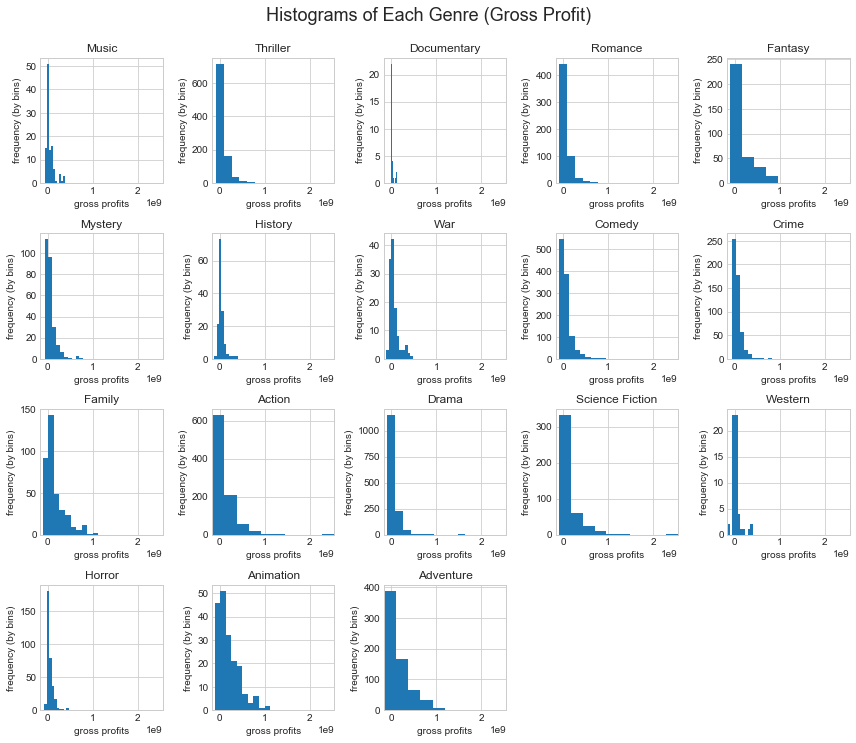

In [13]:
# hist plot of diff genres gross profits
i = 1
fig=plt.figure(figsize=(12,12))

xmin = moviedata['gross'].min()
xmax = moviedata['gross'].max()
for genre in genres:
    plt.subplot(5, 5, i)
    
    i = i + 1
    plt.hist(genres[genre]['gross'],bins=10)
    plt.xlim(xmin,xmax)
    plt.xlabel('gross profits')
    plt.ylabel('frequency (by bins)')
    plt.title(genre)

fig.suptitle('Histograms of Each Genre (Gross Profit)', fontsize=18, y=1.03)
plt.tight_layout()
plt.show()

_Based on the histogram plots, most genres appear to be left skewed_

__Create QQ Plots of Genres to check for normality:__

In [14]:
def plot_qq(series, loc=1,color='royalblue'):
    # creating random normal sampling for qq plot
    norm = np.random.normal(0, 1, series.count())

    # Sorting the values in ascending order.
    norm.sort()
    series = series.sort_values()
    
    # Plotting a genre sample against norm in qqplot.
    plt.subplot(5, 5, loc)
    plt.plot(norm, series, "o", color =color)
    
# --currently not used
def plot_qqneat(series):
    # example qq plot
    a = np.random.normal(5,5,250)
    b = np.random.rayleigh(5,250)

    percs = np.linspace(0,100,21)
    qn_a = np.percentile(a, percs)
    qn_b = np.percentile(b, percs)

    plt.plot(qn_a,qn_b, ls="", marker="o")

    x = np.linspace(np.min((qn_a.min(),qn_b.min())), np.max((qn_a.max(),qn_b.max())))
    plt.plot(x,x, color="k", ls="--")

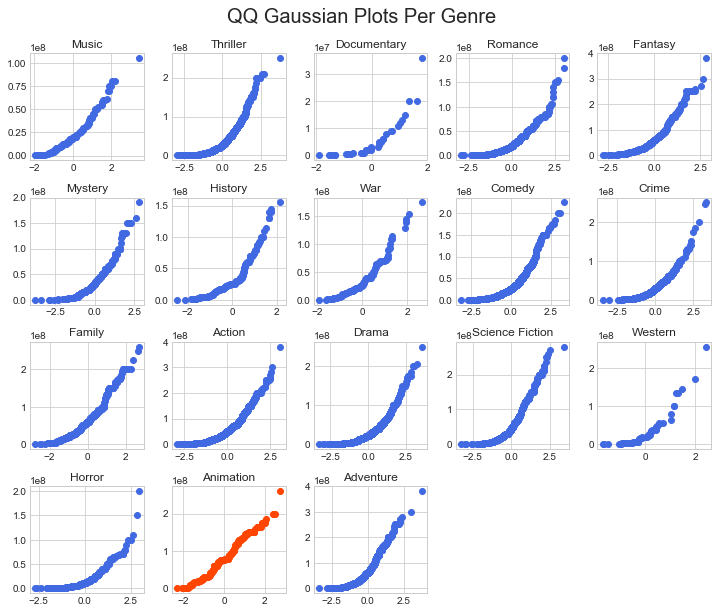

In [15]:
# qq plots of genres
i = 1
fig=plt.figure(figsize=(10,10))

for genre in genres:
    if genre == 'Animation':
        plot_qq(genres[genre]['budget'],i,'orangered')
    else:
        plot_qq(genres[genre]['budget'],i)
    i = i + 1
    plt.title(genre)

fig.suptitle('QQ Gaussian Plots Per Genre', fontsize=20, y=1.03)
plt.tight_layout()
plt.show()

_Exponential curves in QQ plots indicates most genres are left skewed. Animation appears more linear so it could have a normal distribution._

__Mann Whitney U test for non-parametric data:__

In [16]:
#Ex U-test with scip for nonparametric
mannwhitneyu(genres['Action']['budget'], genres['Crime']['budget'], use_continuity=True, alternative=None)

MannwhitneyuResult(statistic=164954.5, pvalue=5.950051344212043e-23)

_MannWhitney U test has a p value that is well below 1%. Indicates likelihood of variability in movie budgets between Action and Crime genres._

__...if data were normally distributed:__

In [17]:
#Ex T-Test with scipy for parametric
t, p = ttest_ind(genres['Action']['budget'], genres['Crime']['budget'], equal_var=False)
print('tvalue: {}, pvalue:{}'.format(t,p))

tvalue: 11.746681548679557, pvalue:1.7364119979308415e-30


In [18]:
# T-Test Raw Calculation for parametric data

# Compute the difference between the two sample means.
diff=dfGenre.loc['Action','budget_avg'] - dfGenre.loc['Crime','budget_avg']

# size of samples
size = np.array([dfGenre.loc['Action','budget_cnt'], dfGenre.loc['Crime','budget_cnt']])
# sample distribution
sd = np.array([dfGenre.loc['Action','budget_std'], dfGenre.loc['Crime','budget_std']])

# The squared standard deviations are divided by the sample size and summed, then we take
# the square root of the sum. 
diff_se = (sum(sd ** 2 / size)) ** 0.5

print(diff/diff_se)

11.746681548679538


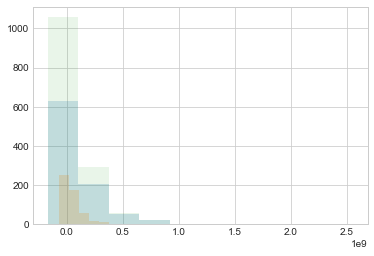

In [26]:
# example hist stacking

plt.hist(genres['Action']['gross'],bins=10,alpha=0.2)
plt.hist(genres['Crime']['gross'],bins=10,alpha=0.2)

total = pd.concat([genres['Action']['gross'],genres['Crime']['gross']])
plt.hist(total,bins=10,alpha=0.1)
plt.show()

##  Part 3: Check 'budget' and 'gross' data for each genre

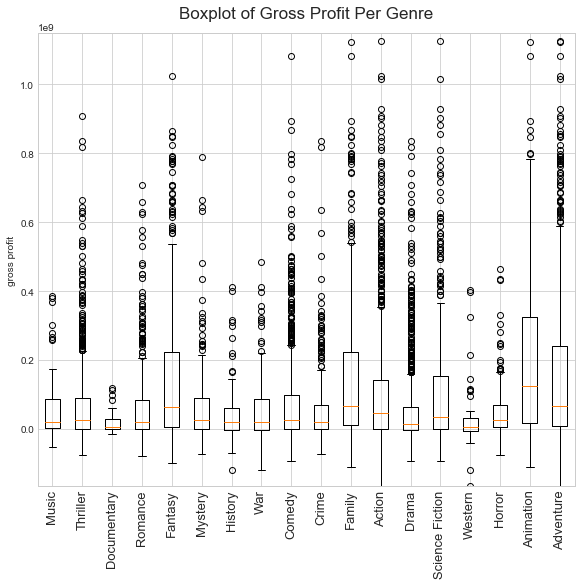

In [20]:
def ser_con(genre): return genres[genre]['gross']

plt.figure(figsize=(8,8))
plt.boxplot(list(map(ser_con, un_genre)))
plt.xticks(list(range(1,19)), un_genre, rotation=90, fontsize=13)
plt.ylim(moviedata['gross'].min(), moviedata['gross'].max()*.45)
plt.tight_layout()
plt.ylabel('gross profit')
plt.title('Boxplot of Gross Profit Per Genre', fontsize=17,y=1.02)
plt.show()

_Animation films appear to have the best gross profit between the inner and upper quartile range. <br>Romance, Horror, and Music genres seem to trend towards a positive gross profit albeit their upper quartile ranges are smaller than other high grossing genres.<br> The lower quartile range of Action and Adventure genres seem to show a larger range of financial loss._

_NOTE TO SELF: Why do many genres have a large number of outliers beyond the maximum value_

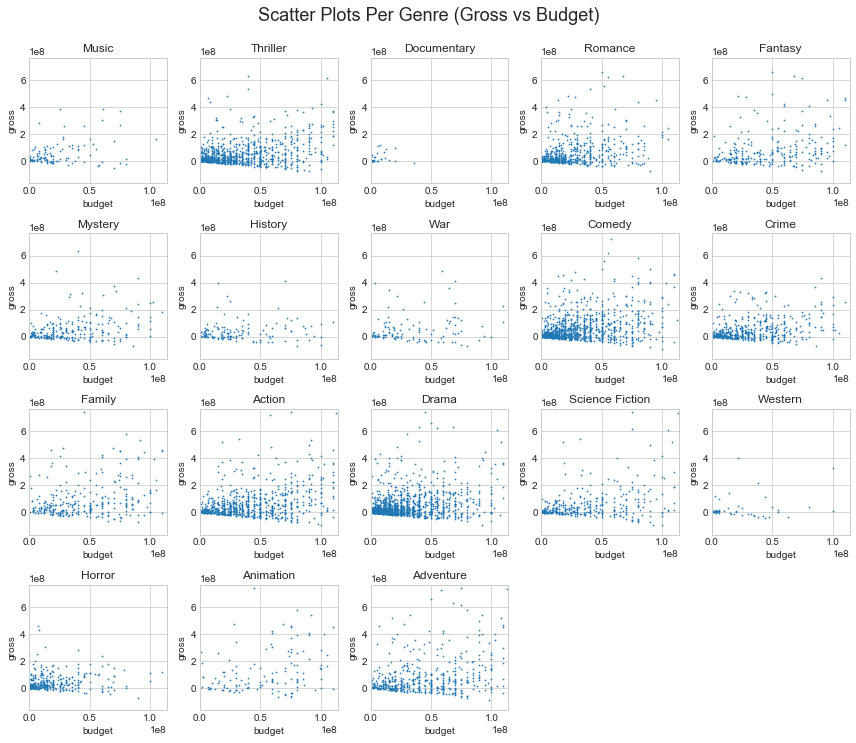

In [21]:
# plot of expense(x) to gross (y)
correlation = {}
i = 1
fig=plt.figure(figsize=(12,12))

xmin = moviedata['budget'].min()
xmax = moviedata['budget'].max()*.3
ymin = moviedata['gross'].min()
ymax = moviedata['gross'].max()*.3

for genre in genres:
    plt.subplot(5, 5, i)
    i = i + 1
    plt.scatter(genres[genre]['budget'],genres[genre]['gross'],.5)
    
    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)
    plt.title(genre)
    plt.xlabel('budget')
    plt.ylabel('gross')
    
    correlation[genre] = (genres[genre]['budget'].corr(genres[genre]['gross']))

fig.suptitle('Scatter Plots Per Genre (Gross vs Budget)', fontsize=18, y=1.03)
plt.tight_layout()
plt.show()

_The scatter plots show a better visualization of the outliers. A comparatively large number of Western films seem to have lost money. War films appear to have a wider range of profit (and or loss)._

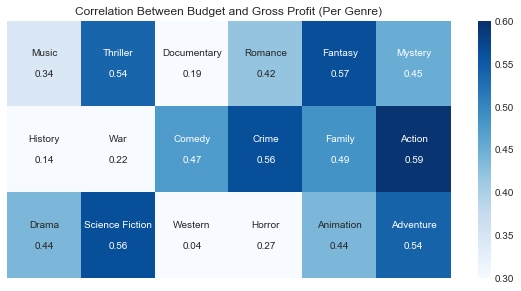

In [22]:
corr = np.array((list(correlation.values())))
labels = (np.asarray(["{}\n\n{:.2f}".format(string, value) \
        for string, value in zip(list(correlation.keys()),corr)])).reshape(3, 6)

fig, ax = plt.subplots(figsize=(8,4))
sns.heatmap(corr.reshape(3,6), 
            annot=labels, 
            square=False, 
            ax=ax, 
            fmt="", 
            xticklabels=False, 
            yticklabels=False, 
            cmap="Blues", 
            vmin=.3, 
            vmax=.6)
plt.tight_layout()
plt.title('Correlation Between Budget and Gross Profit (Per Genre)')
plt.show()

_Genres that are dark blue (Action, Fantasy, Science Fiction) have the highest correlation between budget and profit. <br>Genres that are white (Western, Horror, War, and History) have low correlation between budget and profit._

##  Part 4: Conclusion

__Question Conclusions:__ <br>
<ol><li>Movies categorized by genre do not have normal distributions for budget (with the possible exception of the Animation genre). These genres appear to be left skewed.<br><br><li>There is statistically significant variation between genres (using the Mann Whitney U test) with regards to budget.<br><br><li>Animation films seem to have the highest median gross profit.

There are statistically significant differences between different genres with regards to budget and gross profit. This could help investors decide which films they would want to invest in. However, there does not immediately appear to be a strong correlation between the budgeting of a film (per genre) and gross profit. 

__(Possible) Hypothesis:__ Budget for action, fantasy, and/or science fiction films will predict gross profit with some degree of success.

__Difficulties:__ <ol><li>The data correlations aren't that high<li>Dataset is only a collection of relatively successful films<li>Plotting 20 genres with subplots <li>Mapping Genre DFs to PLT<li>Scatter plots are misleading (with regards to the y-axis)